# Accretion onto a compact object

### Lifetimes of stars with central black holes


[Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_ \
$^3$_Yale University, New Haven, CT_

In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import integrate
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from astropy import constants as cnt
from astropy import units as unt

import dask.dataframe as dd
import dask.array as da

from uncertainties import ufloat, unumpy

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from ipywidgets import interact, FloatSlider, IntSlider

#import tomso
#import tomso.gyre as gyre
#import tomso.fgong as fgong
#import mistery

In [2]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [3]:
# labels 
density     = r'density $\mathbf{\rho~/~[g/cm^3]}$'
frac_radius = r'fractional radius $\mathbf{r/R_\odot}$'
frac_mass   = r'fractional mass $\mathbf{m/M_\odot}$'
Teff        = r'effective temperature $\mathbf{T_{eff}/K}$'
luminosity  = r'luminosity $\mathbf{L/L_\odot}$'

In [4]:
dirs = os.listdir('work')
dirs = [d for d in dirs if d.startswith('M=')]

data = []
for d in dirs:
    M, Z = d.split('_')
    M = float(M[2:])
    Z = float(Z[2:])
    file_path = os.path.join('work', d, 'profile1.data')
    df = pd.read_table(file_path, sep='\s+', skiprows=5)
    csound = df['csound'].iloc[-1]
    opacity = df['opacity'].iloc[-1]
    density = 10**df['logRho'].iloc[-1]
    
    R = 10**df['logR'].iloc[1] 
    T = 10**df['logT'].iloc[1] 
    #print(M, R, T)
    #L = ((4 * np.pi * ((R/cnt.R_sun)**2) * cnt.sigma_sb * ((T*unt.K)**4)))*cnt.L_sun#.value
    L = R**2 * (T/5772)**4#((T*unt.K)**4)))*cnt.L_sun#.value
    data.append((M, Z, csound, opacity, density, L))

df = pd.DataFrame(data, columns=['M', 'Z', 'csound', 'opacity', 'density', 'luminosity'])

# sort the data to ensure lines are connected correctly in the plot
df.sort_values(['M', 'Z'], inplace=True)

Z_values = df['Z'].unique()

df

,M,Z,csound,opacity,density,luminosity
0,0.8,0.0002,5.522110e+07,0.996188,99.693325,6.275252e-01
1,0.8,0.0020,5.449869e+07,1.105752,96.446260,5.355466e-01
2,0.8,0.0200,5.154136e+07,1.961860,79.354329,2.623010e-01
3,0.8,0.0300,5.092625e+07,2.334109,75.493368,2.348211e-01
12,1.0,0.0002,5.963278e+07,0.781305,102.565401,1.778841e+00
13,1.0,0.0020,5.881307e+07,0.857135,98.218463,1.477181e+00
14,1.0,0.0200,5.525391e+07,1.471892,77.921683,7.134916e-01
15,1.0,0.0300,5.441985e+07,1.741846,72.760330,6.242218e-01
20,2.0,0.0002,7.551777e+07,0.461247,98.903835,3.293772e+01
21,2.0,0.0020,7.370954e+07,0.487678,87.313114,2.899259e+01


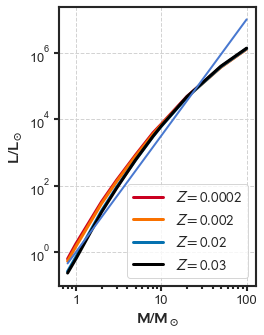

In [5]:
plt.figure(figsize=(4, 5))

colors = {0.03: 'black', 0.02: blue, 0.002: orange, 0.0002: red}

for Z in Z_values:
    subset = df[df['Z'] == Z]
    plt.plot(subset['M'], subset['luminosity'], label=f'$Z={Z}$', lw=3, c=colors[Z])

plt.semilogy()
plt.semilogx()

plt.plot(subset['M'], subset['M']**3.5)

plt.xlabel(r'$\mathbf{M/M_\odot}$')
plt.ylabel('$\mathbf{L/L_\odot}$')
plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

plt.grid(c='lightgray', ls='--')

plt.legend()
plt.tight_layout()
plt.savefig('figs/zams_luminosity.pdf')
plt.show()

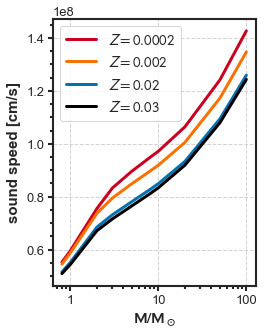

In [6]:
plt.figure(figsize=(4, 5))

colors = {0.03: 'black', 0.02: blue, 0.002: orange, 0.0002: red}

for Z in Z_values:
    subset = df[df['Z'] == Z]
    plt.plot(subset['M'], subset['csound'] / 1e8, label=f'$Z={Z}$', lw=3, c=colors[Z])

#plt.semilogy()
plt.semilogx()

#plt.plot(subset['M'], np.log10(subset['M']) * 3.8e7 + 5.7e7, lw=5, c='k', ls='--')
#plt.plot(subset['M'], np.log10(subset['M']) * 4e7 + 6e7, lw=5, c='k', ls='--') # LOW Z

#plt.plot(M, u)

plt.xlabel(r'$\mathbf{M/M_\odot}$')
plt.ylabel('sound speed [10$^\mathbf{8}$ cm/s]')
plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

plt.grid(c='lightgray', ls='--')

plt.legend()
plt.tight_layout()
plt.savefig('figs/zams_csound.pdf')
plt.show()

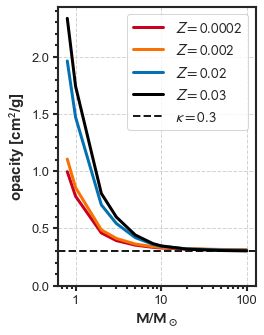

In [7]:
plt.figure(figsize=(4, 5))

for Z in Z_values:
    subset = df[df['Z'] == Z]
    plt.plot(subset['M'], subset['opacity'], label=f'$Z={Z}$', lw=3, c=colors[Z])

kappa = subset['opacity'].min()
plt.axhline(kappa, ls='--', c='k', zorder=-99,
           label=f'$\kappa={str(kappa)[:3]}$')

#f = lambda x: np.power(0.05, x)*1.2 + 0.3
#f = lambda x: np.power(0.05, x)*0.5 + 0.3 # LOW Z

#plt.plot(subset['M'], f(np.log10(subset['M'])), label='fit', c='purple', lw=3, ls='--')
#plt.plot(M, k, label='adfsa')

#plt.semilogy()
plt.semilogx()
plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

plt.grid(c='lightgray', ls='--')

plt.gca().set_yticks([0, 0.5, 1, 1.5, 2])

plt.xlabel(r'$\mathbf{M/M_\odot}$')
plt.ylabel('opacity [cm$^\mathbf{2}$/g]')
plt.legend()
plt.tight_layout()
plt.savefig('figs/zams_kappa.pdf')
plt.show()

In [8]:
subset.columns

Index(['M', 'Z', 'csound', 'opacity', 'density', 'luminosity'], dtype='object')

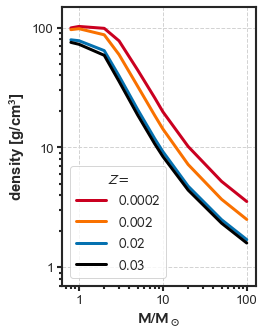

In [9]:
plt.figure(figsize=(4, 5))

for Z in Z_values:
    subset = df[df['Z'] == Z]
    plt.plot(subset['M'], subset['density'], label=f'${Z}$', lw=3, c=colors[Z])

plt.semilogx()
plt.semilogy()
plt.ylim([0.7e0, 1.5e2])
plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

plt.gca().set_yticks([1, 10, 100])
plt.gca().set_yticklabels([1, 10, 100])

# -1.57331261,  3.1325722 ,  1.01955322,  2.08820435
# plt.plot(subset['M'], 10**(-1.57/(1+np.exp(-3.13*(x_data - 1.02)))+2.1), c='darkgray', ls='--') # LOW Z

plt.grid(c='lightgray', ls='--')

plt.xlabel(r'$\mathbf{M/M_\odot}$')
plt.ylabel(r'density [g/cm$^\mathbf{3}$]')
plt.legend(title=r'$Z =$', title_fontsize=14)
plt.tight_layout()
plt.savefig('figs/zams_rho.pdf')
plt.show()

In [10]:
from scipy.optimize import curve_fit

# Data points
subset = df[df['Z'] == 0.02]
x_data = np.log10(subset['M'].values)
y_data = np.log10(subset['density'].values)

# Sigmoid function to fit to the data
def sigmoid(x, L, k, x0, y0):
    return L / (1 + np.exp(-k * (x - x0))) + y0

# Initial guess for the parameters (L, k, x0) = (75, 1, 0)
p0 = 2,2,2,2#[80, -4, 0.5, 3.5]

# Use curve_fit to find the best parameters
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)

popt

array([-1.88816029,  2.67234489,  0.88851964,  2.06057489])

In [11]:
subset = df[df['Z'] == 0.0002]
curve_fit(sigmoid, np.log10(subset['M'].values), np.log10(subset['density'].values), p0)

(array([-1.57331261,  3.1325722 ,  1.01955322,  2.08820435]),
 array([[ 0.01083966,  0.04164613, -0.00138422, -0.00436267],
        [ 0.04164613,  0.19707027, -0.00525488, -0.01758874],
        [-0.00138422, -0.00525488,  0.00151256, -0.00031034],
        [-0.00436267, -0.01758874, -0.00031034,  0.00255248]]))

In [12]:
-2/(1+np.exp(-3*(x_data - 1)))+2

array([1.92821885, 1.90514825, 1.78120497, 1.65517821, 1.42316816,
       1.1443497 , 1.        , 0.57683184, 0.21879503, 0.09485175])

[]

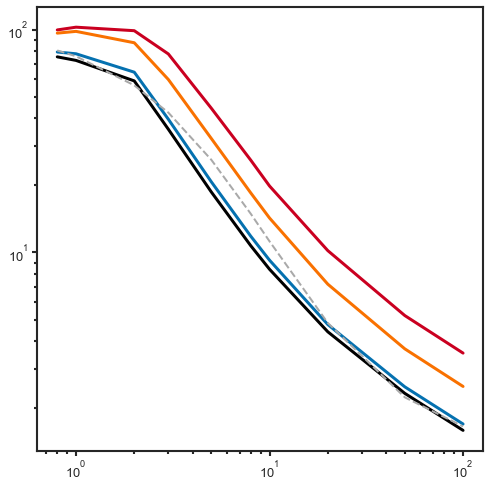

In [13]:
plt.figure(figsize=(8,8))

for Z in Z_values:
    subset = df[df['Z'] == Z]
    plt.plot(subset['M'], subset['density'], label=f'$Z={Z}$', lw=3, c=colors[Z])

#plt.plot(-30 * subset['M'] + 0.8e3)
#plt.plot(subset['M'], -30 * np.log10(subset['M']) + 72, lw=3, c='darkgray', ls='--')
#plt.plot(subset['M'], sigmoid(x_data, 80, -4, 0.5, 3.5), lw=3, c='darkgray', ls='--')
#plt.plot(subset['M'], 10**(sigmoid(x_data, *popt)), lw=3, c='darkgray', ls='--')

plt.plot(subset['M'], 10**(-1.9/(1+np.exp(-2.7*(x_data - 1)))+2), c='darkgray', ls='--')

plt.semilogx()
plt.semilogy()

\begin{align}
c_s &= 3.8 \times 10^7 \log_{10}{M_\ast} + 5.7 \times 10^7\\
\kappa &= 0.8 \times M_\ast^{-1.7} + 0.3 \\
\log_{10} \rho &= \dfrac{-1.9}{1 + \exp\{- 2.7 (\log_{10} (M_\ast) - 1) \}} + 2
\end{align}

In [14]:
M = np.linspace(0.8, 100, 1000)
u = np.log10(M) * 3.8e7 + 5.7e7
k = 0.3 + 1.2 * M**-1.3 #0.3 + 0.8 * M**-1.7
rho = 10**(-1.9 / (1 + np.exp(-2.7 * (np.log10(M) - 1))) + 2)

# equation to solve
#eq = 4*pi*G*c/k*M_BH - 16*pi*0.08*(1-0.08)*rho/(u*(5/3))*(G*M_BH)**2

In [15]:
#M = np.linspace(0.8, 100, 1000)
u_ = lambda M: np.log10(M) * 3.8e7 + 5.7e7
k_ = lambda M: 0.3 + 1.2 * M**-1.3
rho_ = lambda M: 10**(-1.9 / (1 + np.exp(-2.7 * (np.log10(M) - 1))) + 2)

In [16]:
u_lZ = lambda M: np.log10(M) * 4e7 + 6e7
k_lZ = lambda M: np.power(0.05, M)*0.5 + 0.3
rho_lZ = lambda M: 10**(-1.57/(1+np.exp(-3.13*(np.log10(M) - 1.02)))+2.1)

In [17]:
cnt.M_sun.cgs.value

1.988409870698051e+33

In [18]:
pi = np.pi
G = cnt.G.cgs.value
c = cnt.c.cgs.value
M_sun = cnt.M_sun.cgs.value
L_sun = cnt.L_sun.cgs.value

In [19]:
eddington = lambda M, M_BH: 4*pi*G*c/k_(M)*M_BH*M_sun
bondi = lambda M, M_BH: 16*pi*0.1*rho_(M)/(u_(M)*(5/3))*(G*M_BH*M_sun)**2
diff = lambda M, M_BH: eddington(M, M_BH) - bondi(M, M_BH)

In [20]:
eddington_lZ = lambda M, M_BH: 4*pi*G*c/k_lZ(M)*M_BH*M_sun
bondi_lZ = lambda M, M_BH: 16*pi*0.1*rho_lZ(M)/(u_lZ(M)*(5/3))*(G*M_BH*M_sun)**2
diff_lZ = lambda M, M_BH: eddington_lZ(M, M_BH) - bondi_lZ(M, M_BH)

In [21]:
from scipy.optimize import root

In [22]:
root(lambda x0: diff(0.1, x0), x0=5).x[0]

7.523247306610365e-12

In [23]:
diff(M, -12)#/cnt.L_sun.cgs.value

array([-1.15685703e+49, -1.08356688e+49, -1.01963149e+49, -9.62969517e+48,
       -9.12140502e+48, -8.66107237e+48, -8.24097882e+48, -7.85521876e+48,
       -7.49916476e+48, -7.16911565e+48, -6.86205762e+48, -6.57549792e+48,
       -6.30734611e+48, -6.05582781e+48, -5.81942060e+48, -5.59680579e+48,
       -5.38683142e+48, -5.18848365e+48, -5.00086411e+48, -4.82317203e+48,
       -4.65468978e+48, -4.49477111e+48, -4.34283156e+48, -4.19834047e+48,
       -4.06081433e+48, -3.92981120e+48, -3.80492593e+48, -3.68578615e+48,
       -3.57204880e+48, -3.46339708e+48, -3.35953790e+48, -3.26019957e+48,
       -3.16512982e+48, -3.07409403e+48, -2.98687368e+48, -2.90326496e+48,
       -2.82307754e+48, -2.74613346e+48, -2.67226615e+48, -2.60131951e+48,
       -2.53314716e+48, -2.46761163e+48, -2.40458377e+48, -2.34394208e+48,
       -2.28557223e+48, -2.22936652e+48, -2.17522339e+48, -2.12304706e+48,
       -2.07274712e+48, -2.02423815e+48, -1.97743941e+48, -1.93227455e+48,
       -1.88867130e+48, -

In [24]:
cnt.L_sun.cgs

<Quantity 3.828e+33 erg / s>

In [25]:
L_BH = lambda M, M_BH: np.min([bondi(M, M_BH)/L_sun, eddington(M, M_BH)/L_sun])
L_BH_lZ = lambda M, M_BH: np.min([bondi_lZ(M, M_BH)/L_sun, eddington_lZ(M, M_BH)/L_sun])
L_MS = lambda M: M**3.5
L_BH(1, 1e-5)

0.08707209878348385

1 4.711191961807593e-10


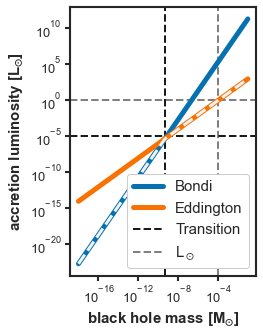

In [26]:
plt.figure(figsize=(4, 5))

M_BH = 10**np.linspace(-18, -1, 100)
plt.semilogx()
plt.semilogy()
#plt.yscale('symlog', linthresh=1e16)#, linthreshy=1e8)
plt.axhline(0, ls='--', c='k', zorder=-99)
plt.plot(M_BH, bondi(1, M_BH)/L_sun, c=blue, lw=5, label='Bondi')
plt.plot(M_BH, eddington(1, M_BH)/L_sun, c=orange, lw=5, label='Eddington')
pairmin = [np.min([e,b]) for e, b in zip(eddington(1, M_BH), bondi(1, M_BH))]
plt.plot(M_BH, pairmin/L_sun, ls='--', lw=3, c='#f2f2f2', label=r'')


for M in [1]:
    #plt.axvline(M_BH[np.abs(diff(M, M_BH)).argmin()], ls='--', c='lightgray')
    BET = root(lambda x0: diff(M, x0), x0=5).x[0]
    plt.axhline(1e-5, ls='--', c='k', zorder=-99, lw=2)
    plt.axvline(BET, ls='--', c='k', zorder=-99, lw=2, label='Transition')
    print(M, BET)

#plt.gca().set_yticks([-1e34, -1e22, 0, 1e22, 1e34])
plt.axhline(1, ls='--', c='gray', zorder=-999, label=r'L$_\odot$')
plt.axvline(1e-4, ls='--', c='gray', zorder=-999)

plt.gca().set_xticks([1e-4, 1e-8, 1e-12, 1e-16])

#plt.set

plt.legend(loc='lower right', framealpha=1)
plt.xlabel(r'black hole mass [M$_\mathbf{\odot}$]')
plt.ylabel(r'accretion luminosity [L$_\mathbf{\odot}$]')
plt.tight_layout()
plt.savefig('figs/bondi-edd-solarzams.pdf')
plt.show()

0.2 2.987039421641167e-11
1 4.711191961807593e-10
10 2.2128251360077152e-08
100 2.4913630511361847e-07


C:\Users\earlb\AppData\Local\Temp\ipykernel_15528\2390525882.py:7: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axhline(0, ls='--', c='k', zorder=-99)


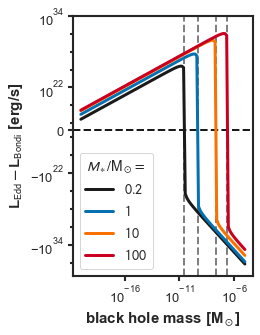

In [27]:
plt.figure(figsize=(4, 5))

M_BH = 10**np.linspace(-20, -5, 100)
plt.semilogx()
#plt.semilogy()
plt.yscale('symlog', linthresh=1e16)#, linthreshy=1e8)
plt.axhline(0, ls='--', c='k', zorder=-99)
plt.plot(M_BH, diff(0.2, M_BH), label=r'$0.2$', c='k', lw=3)
plt.plot(M_BH, diff(1, M_BH), label=r'$1$', c=blue, lw=3)
plt.plot(M_BH, diff(10, M_BH), label=r'$10$', c=orange, lw=3)
plt.plot(M_BH, diff(100, M_BH), label=r'$100$', c=red, lw=3)

for M in [0.2, 1, 10, 100]:
    #plt.axvline(M_BH[np.abs(diff(M, M_BH)).argmin()], ls='--', c='lightgray')
    BET = root(lambda x0: diff(M, x0), x0=5).x[0]
    plt.axvline(BET, ls='--', c='gray', zorder=-99, lw=2)
    print(M, BET)

plt.gca().set_yticks([-1e34, -1e22, 0, 1e22, 1e34])
#plt.gca().set_yticks([-1e30, -1e15, 0, 1e15, 1e30])
#plt.gca().set_yticks([-1e30, -1e20, 0, 1e20, 1e30])
#plt.gca().set_yticks([-1e1, 0, 1e1])

plt.legend(loc='lower left', title=r'$M_\ast/$M$_\odot =$', fontsize=14, title_fontsize=14)
plt.xlabel(r'black hole mass [M$_\odot$]')
plt.ylabel(r'$\mathbf{L_{\rm{Edd}} - L_{\rm{Bondi}}}$ [erg/s]')
plt.tight_layout()
plt.savefig('figs/bondi-edd-pbh.pdf')
plt.show()

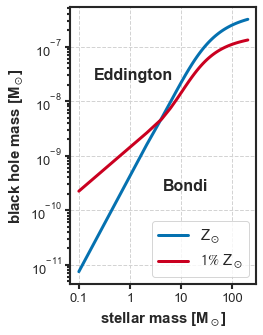

In [28]:
plt.figure(figsize=(4, 5))

Ms = np.linspace(0.1, 200, 100)
BETs = []

for M in Ms:
    BETs += [root(lambda x0: diff(M, x0), x0=5).x[0]]

#plt.plot(Ms, 4e-10*Ms**1.7, c='k')
#plt.plot(Ms, 15e-10*Ms**0.9, c='gray')

plt.plot(Ms, BETs, lw=3, c=blue, label=r'Z$_\odot$')

BETs_lZ = []
for M in Ms:
    BETs_lZ += [root(lambda x0: diff_lZ(M, x0), x0=5).x[0]]
plt.plot(Ms, BETs_lZ, lw=3, c=red, label=r'$1\%$ Z$_\odot$')

plt.semilogx()
plt.semilogy()

plt.gca().set_xticks([0.1, 1, 10, 100])
plt.gca().set_xticklabels(['0.1', '1', '10', '100'])

plt.text(4.4, 2.3e-10, 'Bondi', size=16, weight='bold')
plt.text(0.2, 2.5e-8, 'Eddington', size=16, weight='bold')

plt.grid(c='lightgray', ls='--')
plt.legend(loc='lower right')

plt.xlabel(r'stellar mass [M$_\odot$]')
plt.ylabel(r'black hole mass [M$_\odot$]')
plt.tight_layout()
plt.savefig('figs/bondi-edd-m.pdf')
plt.show()

In [29]:
def bet(x, a, b):
    return 10**(a+b*np.log10(x))

curve_fit(bet, Ms, BETs, [1/1e9, 1])[0]

def bet(x, a, b):
    return a*x**b

curve_fit(bet, Ms, BETs, [6*10**-10, 1.5])[0]

curve_fit(bet, Ms, BETs_lZ, [6*10**-10, 1.5])[0]


array([1.21219248e-08, 4.65295929e-01])

In [30]:
BET_ = lambda M: 4e-10*M**1.7 #5.5*10**-10*M**1.5
BET_lZ = lambda M: 15e-10*M**0.9
BET_(1)

4e-10

In [31]:
eps = 0.08
eta = 0.1 

tau_Bondi = lambda M: eps/(1-eps)/eta*c**2*(5/3)*u_(M)/(16*pi*G**2*rho_(M))
tau_Bondi_lZ = lambda M: eps/(1-eps)/eta*c**2*(5/3)*u_lZ(M)/(16*pi*G**2*rho_lZ(M))

tau_Bondi(1)

4.367523441645747e+39

In [32]:
secGyr = (365*24*60*60)*1e9#(1*unt.s)/(1*unt.yr)
secGyr

3.1536e+16

In [33]:
BET_(1)

4e-10

In [34]:
BET_(M)/M_sun

1.641742623337195e-39

In [35]:
t_bondi = lambda M, M_BH: tau_Bondi(M) * -(1/BET_(M)/M_sun - 1/M_BH/M_sun)/secGyr
t_bondi_lZ = lambda M, M_BH: tau_Bondi_lZ(M) * -(1/BET_lZ(M)/M_sun - 1/M_BH/M_sun)/secGyr
#root(lambda x0: t_bondi(1, 10**x0), x0=-9.26)
t_bondi(1, 1e-12)

69.47613201133292

In [36]:
eps=0.08
tau_edd = lambda M: ((1-eps)/eps*4*pi*G/c/k_(M))**-1
tau_edd_lZ = lambda M: ((1-eps)/eps*4*pi*G/c/k_lZ(M))**-1
tau_edd(1)

4662281951636300.0

In [37]:
np.log((1 / (1e-8 if 1e-8>=BET_(1) else np.nan)))

18.420680743952367

In [38]:
t_edd = lambda M, M_BH: tau_edd(M) * np.log((M / (M_BH if M_BH>=BET_(M) else np.nan))) / secGyr
t_edd_lZ = lambda M, M_BH: tau_edd_lZ(M) * np.log((M / (M_BH if M_BH>=BET_lZ(M) else np.nan))) / secGyr
t_edd(1, 1e-2)

0.68082831818702

In [39]:
Ms_linspace = 10**np.linspace(np.log10(0.2), np.log10(200), 2000)
M_BH_linspace = 10**np.linspace(-10, 3, 2000)
t_edd_grid = np.array([[t_edd(Mstar, MBH) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
t_edd_grid[t_edd_grid < 0] = np.nan
t_edd_grid[t_edd_grid > 100] = 100

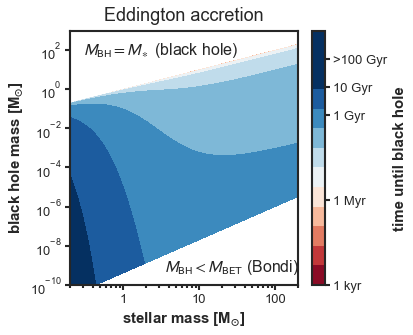

In [40]:
levels = 1/np.array([1e-6, 1e-3, 1, 10, 100])[::-1]

ticks = [1e-6, 1e-3, 1, 10, 100]
levels = 10**np.linspace(-6, 3, 14)

# Create the contour plot
plt.figure(figsize=(4*(3/2), 5))
contour = plt.contourf(
    Ms_linspace, M_BH_linspace, t_edd_grid, 
    norm=mpl.colors.LogNorm(vmin=1e-6, vmax=15),
    cmap='RdBu', levels=levels)

plt.semilogy()
plt.semilogx()

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

# Add colorbar and labels
cbar = plt.colorbar(contour)
cbar.set_label('time until black hole')

plt.text(3.5, 5e-10, r'$M_{\rm{BH}} < M_{\rm{BET}}$ (Bondi)', size=16)
plt.text(0.3, 6e1, r'$M_{\rm{BH}} = M_\ast$ (black hole)', size=16)

# Set colorbar ticks and labels
cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 kyr', '1 Myr', '1 Gyr', '10 Gyr', '>100 Gyr'])

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('black hole mass [M$_{\mathbf{\odot}}$]')

plt.title('Eddington accretion')

plt.tight_layout()
#plt.savefig('figs/edd-time.pdf')
plt.show()

In [41]:
10**np.linspace(-6, 3, 14)

array([1.00000000e-06, 4.92388263e-06, 2.42446202e-05, 1.19377664e-04,
       5.87801607e-04, 2.89426612e-03, 1.42510267e-02, 7.01703829e-02,
       3.45510729e-01, 1.70125428e+00, 8.37677640e+00, 4.12462638e+01,
       2.03091762e+02, 1.00000000e+03])

In [42]:
Ms_grid, M_BH_grid = np.meshgrid(10**np.linspace(np.log10(0.2), np.log10(200), 100), 
                                 10**np.linspace(-12, -5.5, 100))

t_bondi_grid = t_bondi(Ms_grid, M_BH_grid)
t_bondi_grid[t_bondi_grid < 0] = np.nan
t_bondi_grid[t_bondi_grid > 100] = 100

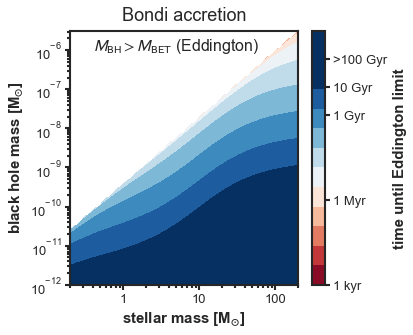

In [43]:
levels = 1/np.array([1e-6, 1e-3, 1, 10, 100])[::-1]

ticks = [1e-6, 1e-3, 1, 10, 100]
#levels = [1e-6, 1e-3, 1, 10, 100]#/50
levels = 10**np.linspace(-6, 3, 14)

# Create the contour plot
plt.figure(figsize=(4*(3/2), 5))
contour = plt.contourf(
    Ms_grid, M_BH_grid, t_bondi_grid, 
    norm=mpl.colors.LogNorm(vmin=1e-6, vmax=15),
    cmap='RdBu', levels=levels)

plt.semilogy()
plt.semilogx()

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

plt.text(0.4, 1e-6, r'$M_{\rm{BH}} > M_{\rm{BET}}$ (Eddington)', size=16)

cbar = plt.colorbar(contour)
cbar.set_label('time until Eddington limit')

cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 kyr', '1 Myr', '1 Gyr', '10 Gyr', '>100 Gyr'])

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('black hole mass [M$_{\mathbf{\odot}}$]')

plt.title('Bondi accretion')

plt.tight_layout()
#plt.savefig('figs/bondi-time.pdf')
plt.show()

In [44]:
#1e-10 > BET_(1)
#t_bondi(1, 1e-10)
#t_edd(1, BET_(1)) 
t_bondi(1, 1e-10) + t_edd(1, BET_(1)) 

3.7215687776793827

In [45]:
lifetime = lambda M, M_BH: t_edd(M, M_BH) if M_BH>=BET_(M) else t_bondi(M, M_BH) + t_edd(M, BET_(M)) 
lifetime_lZ = lambda M, M_BH: t_edd_lZ(M, M_BH) if M_BH>=BET_lZ(M) else t_bondi_lZ(M, M_BH) + t_edd_lZ(M, BET_lZ(M)) 

In [46]:
t_ms = lambda M: 10*M**-2

In [47]:
lifetime(1, 1e-10)

3.7215687776793827

In [48]:
lifetime(100, 10)
#t_ms(100)

0.06876689718455857

In [49]:
dfs = [pd.read_table('sep_pbh_grid/M=1_MBHf=-13_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-12_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-11_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-10.5_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-10_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-8_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-6_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-4_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/M=1_MBHf=-2_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+')]

SunDF = pd.read_table('sep_pbh_grid/normal/LOGS/history.data', skiprows=5, sep='\s+')

In [50]:
10**np.arange(-20, -3, 1, dtype=float)

array([1.e-20, 1.e-19, 1.e-18, 1.e-17, 1.e-16, 1.e-15, 1.e-14, 1.e-13,
       1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04])

In [51]:
SunDF.star_age.values[-1]/1e9
SunDF['star_age'][SunDF['center_h1'].argmin()]/1e9

11.51789752438186

[11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 11.51789752438186, 9.990091966671827, 3.7215687776793827, 3.0637274318415897, 2.72331327274808, 2.38289911365457, 2.04248495456106, 1.70207079546755, 1.36165663637404, 1.02124247728053, 0.68082831818702]


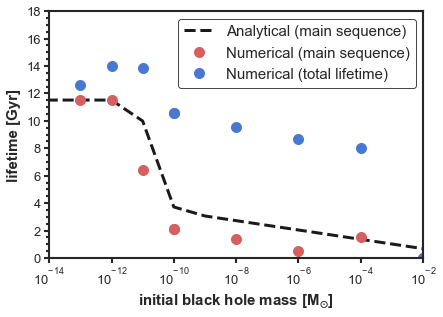

In [52]:
mbhs = 10**np.arange(-20, -1, 1, dtype=float)
ages = []
solt = SunDF['star_age'][SunDF['center_h1'].argmin()]/1e9
for mbh in mbhs:
    ages += [np.min([lifetime(1, mbh), solt])] #[lifetime(1, mbh)]
print(ages)
plt.plot(mbhs, np.array(ages), c='k', ls='--', lw=3, label='Analytical (main sequence)')

#for df in dfs:
#    plt.plot(df['M_BH'].values[0], df['star_age'].values[-1]/1e9, 'k.', ms=20)
for ii, df in enumerate(dfs):
    if ii == 0:
        plt.plot(df['M_BH'].values[0], df['star_age'][df['center_h1'].argmin()]/1e9, 'r.', ms=20, 
                 label='Numerical (main sequence)')
        plt.plot(df['M_BH'].values[0], df['star_age'].values[-1]/1e9, 'b.', ms=20,
                label='Numerical (total lifetime)')
    else:
        plt.plot(df['M_BH'].values[0], df['star_age'][df['center_h1'].argmin()]/1e9, 'r.', ms=20)
        plt.plot(df['M_BH'].values[0], df['star_age'].values[-1]/1e9, 'b.', ms=20)

plt.semilogx()
#plt.semilogy()
plt.xlim([1e-14, 1e-2])
plt.ylim([0, 18])

plt.legend(edgecolor='k')

plt.xlabel(r'initial black hole mass [M$_\mathbf{\odot}$]')
plt.ylabel('lifetime [Gyr]')
plt.tight_layout()
plt.show()

In [53]:
Ms_linspace = 10**np.linspace(np.log10(0.2), np.log10(200), 200)
M_BH_linspace = 10**np.linspace(-18, 3, 200)
lifetime_grid = np.array([[lifetime(Mstar, MBH) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
lifetime_grid[lifetime_grid < 0] = np.nan
lifetime_grid[lifetime_grid > 100] = 100

lifetime_grid2 = np.array([[np.min([lifetime(Mstar, MBH), t_ms(Mstar)]) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
lifetime_grid2[lifetime_grid2 < 0] = np.nan
lifetime_grid2[lifetime_grid2 > 100] = 100

In [54]:
#Ms_linspace = 10**np.linspace(np.log10(0.2), np.log10(200), 2000)
M_BH_frac_linspace = 10**np.linspace(-18, 0, 200)
lifetime_grid3 = np.array([[np.min([lifetime(Mstar, Mstar*MBHf), t_ms(Mstar)]) for Mstar in Ms_linspace]
                       for MBHf in M_BH_frac_linspace])
lifetime_grid3[lifetime_grid3 < 0] = np.nan
lifetime_grid3[lifetime_grid3 > 100] = 100

In [55]:
#t_ms(10)
np.min([lifetime(10, 2), t_ms(10)])

0.05712802786358342

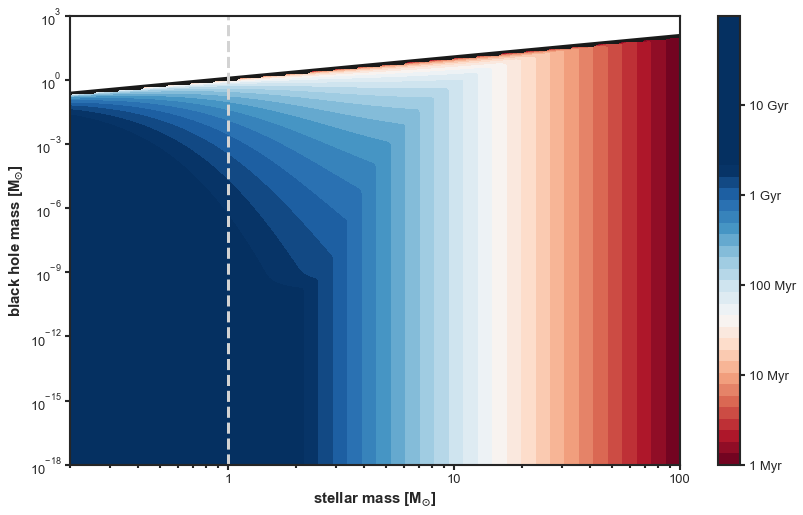

In [56]:
#ticks = #[1e-6, 1e-3, 1, 10, 100]
#levels = 10**np.linspace(-2, 2, 30)
#levels = [0, 25, 50, 75, 100]
levels = np.linspace(0, 100, 10)

ticks = [1e-3, 1e-2, 1e-1, 1, 10]
levels = 10**np.linspace(-3, 2, 40)

plt.figure(figsize=(4*(3), 5*(3/2)))
contour = plt.contourf(
    Ms_linspace, M_BH_linspace, lifetime_grid2, 
    norm=mpl.colors.LogNorm(vmin=1e-3, vmax=2),
    #norm=mpl.colors.Normalize(vmin=0, vmax=100),
    cmap='RdBu', levels=levels)

plt.semilogy()
plt.semilogx()

plt.xlim([0.2, 100])

plt.axvline(1, ls='--', c='lightgray', lw=3)

plt.plot(Ms_linspace, Ms_linspace, c='k', ls='-', lw=6, zorder=-99)

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

cbar = plt.colorbar(contour)
#cbar.set_label('lifetime')

#cbar.set_ticks([0, 25, 50, 75, 100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 Myr', '10 Myr', '100 Myr', '1 Gyr', '10 Gyr'])

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
#plt.savefig('figs/edd-time.pdf')
plt.show()

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


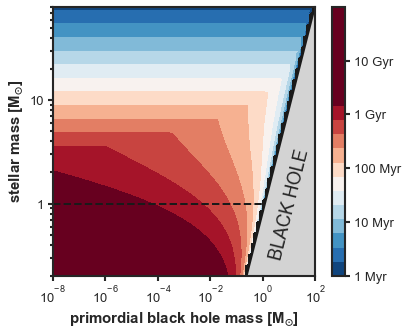

In [57]:
#ticks = #[1e-6, 1e-3, 1, 10, 100]
#levels = 10**np.linspace(-2, 2, 30)
#levels = [0, 25, 50, 75, 100]
levels = np.linspace(0, 100, 10)

ticks = [1e-3, 1e-2, 1e-1, 1, 10]
levels = 10**np.linspace(-3, 2, 20)

plt.figure(figsize=(4*(3/2), 5))
contour = plt.contourf(
    M_BH_linspace, Ms_linspace, lifetime_grid2.T, 
    norm=mpl.colors.LogNorm(vmin=1e-3, vmax=2),
    #norm=mpl.colors.Normalize(vmin=0, vmax=100),
    cmap='RdBu_r', levels=levels)

plt.semilogy()
plt.semilogx()

plt.axhspan(0.1, 100, 1e-18, 1e3, color='lightgray', zorder=-99)

plt.xlim([1e-8, 1e2])
plt.ylim([0.2, 80])

#plt.axvline(1, ls='--', c='lightgray', lw=3, zorder=-99)
#plt.axhline(1, ls='--', c='lightgray', lw=3, zorder=-99)

plt.plot(Ms_linspace, Ms_linspace, c='k', ls='-', lw=6, zorder=-99)

plt.gca().set_yticks([1, 10])
plt.gca().set_yticklabels([1, 10])

cbar = plt.colorbar(contour)
#cbar.set_label('lifetime')

#plt.plot([1e-8, 10], [10, 10], ls='--', c='k')
plt.plot([1e-8, 1], [1, 1], ls='--', c='k')

#cbar.set_ticks([0, 25, 50, 75, 100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 Myr', '10 Myr', '100 Myr', '1 Gyr', '10 Gyr'])

plt.text(1.5e0, 0.3, 'BLACK HOLE', rotation=76, )
plt.ylabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.xlabel('primordial black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/time.pdf')
plt.show()

In [58]:
np.log10(lifetime_grid3[lifetime_grid3>0].min())

-3.6020599913279625

C:\Users\earlb\AppData\Local\Temp\ipykernel_15528\3862778280.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(
C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


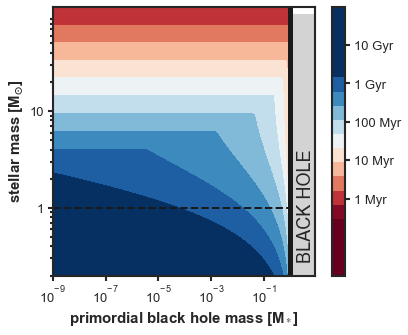

In [59]:
levels = np.linspace(0, 100, 10)

ticks = [1e-3, 1e-2, 1e-1, 1, 10]
levels = 10**np.linspace(-5, 2, 20)

plt.figure(figsize=(4*(3/2), 5))
contour = plt.contourf(
    M_BH_frac_linspace, Ms_linspace, lifetime_grid3.T, 
    norm=mpl.colors.LogNorm(vmin=10**-3.5, vmax=2),
    cmap='RdBu', levels=levels)

plt.semilogy()
plt.semilogx()

plt.axhspan(0.1, 100, 1e-18, 1e3, color='lightgray', zorder=-99)

plt.xlim([1e-9, 9])
plt.ylim([0.2, 120])

#plt.axvline(1, ls='--', c='lightgray', lw=3, zorder=-99)
#plt.axhline(1, ls='--', c='lightgray', lw=3, zorder=-99)

plt.plot(Ms_linspace**0, Ms_linspace, c='k', ls='-', lw=6, zorder=-99)

plt.gca().set_yticks([1, 10])
plt.gca().set_yticklabels([1, 10])

cbar = plt.colorbar(contour)
#cbar.set_label('lifetime')

#plt.plot([1e-8, 10], [10, 10], ls='--', c='k')
plt.plot([1e-9, 1], [1, 1], ls='--', c='k')

#cbar.set_ticks([0, 25, 50, 75, 100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 Myr', '10 Myr', '100 Myr', '1 Gyr', '10 Gyr'])

plt.text(1.8e0, 0.3, 'BLACK HOLE', rotation=90, )
plt.ylabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.xlabel('primordial black hole mass [M$_*$]')

plt.tight_layout()
plt.savefig('figs/time.pdf')
plt.show()

In [60]:
lifetime(1, 1e-10)

3.7215687776793827

In [61]:
lifetime(1, 1e-11)/t_ms(1)

0.9990091966671827

In [62]:
#Ms_linspace_ = Ms_linspace
#M_BH_linspace_ = M_BH_linspace
#frac_grid_ = frac_grid
#lifetime_grid2_ = lifetime_grid2

In [63]:
#Ms_linspace = Ms_linspace_
#M_BH_linspace = M_BH_linspace_
#frac_grid = frac_grid_
#lifetime_grid2 = lifetime_grid2_

In [64]:
Ms_linspace = 10**np.linspace(np.log10(0.2), np.log10(200), 2000)
M_BH_linspace = 10**np.linspace(-18, 3, 2000)
frac_grid = np.array([[lifetime(Mstar, MBH)/t_ms(Mstar)*100 for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
frac_grid[frac_grid < 0] = np.nan
frac_grid[frac_grid > 100] = 100

lifetime_grid2 = np.array([[np.min([lifetime(Mstar, MBH), t_ms(Mstar)]) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
lifetime_grid2[lifetime_grid2 < 0] = np.nan
lifetime_grid2[lifetime_grid2 > 100] = 100

L_MS = lambda M: M**3.5
luminosity_grid = np.array([[L_BH(Mstar, MBH) / L_MS(Mstar) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])

In [65]:
import cmasher as cmr

In [66]:
cmr.prinsenvlag(1)

(0.66968836, 0.32287871, 0.26984798, 1.0)

In [67]:
root(lambda x: lifetime(1, x)/t_ms(1)*100-50, x0=1e-9)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.421e-14]
       x: [ 3.527e-11]
    nfev: 28
    fjac: [[-1.000e+00]]
       r: [ 5.600e+11]
     qtf: [-1.123e-10]

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


[1.e-02 2.e-02 3.e-02 4.e-02 5.e-02 6.e-02 7.e-02 8.e-02 9.e-02 1.e-01
 2.e-01 3.e-01 4.e-01 5.e-01 6.e-01 7.e-01 8.e-01 9.e-01 1.e+00 2.e+00
 3.e+00 4.e+00 5.e+00 6.e+00 7.e+00 8.e+00 9.e+00 1.e+01 2.e+01 3.e+01
 4.e+01 5.e+01 6.e+01 7.e+01 8.e+01 9.e+01]


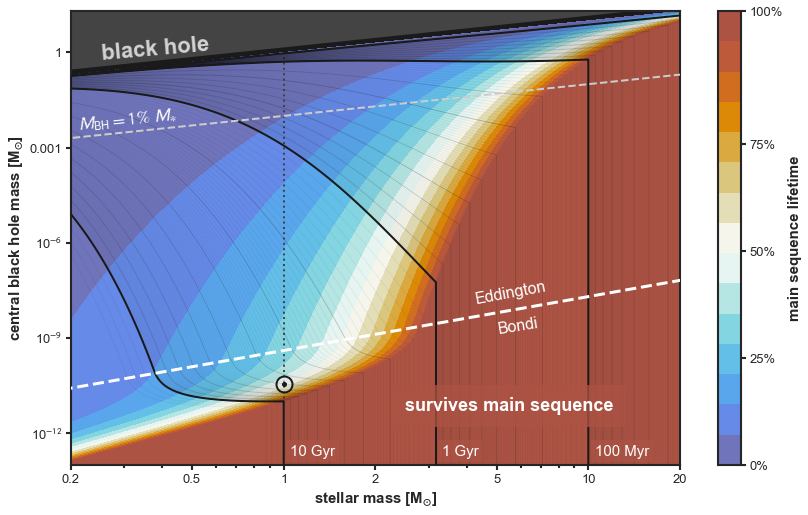

In [68]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
#levels = np.linspace(0, 100, 15)#[0, 25, 50, 75, 100]
levels = list(np.linspace(0, 99, 15)) + [100]#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    Ms_linspace, M_BH_linspace, frac_grid, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

#plt.gca().set_xticks([1, 10, 100])
#plt.gca().set_xticklabels([1, 10, 100])
xticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks)
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.xlim([0.2, 20])
plt.ylim([1e-13, 20])

plt.gca().set_yticks([10**0, 10**-3, 10**-6, 10**-9, 10**-12])
plt.gca().set_yticklabels([r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#ac5344'
plt.axhspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
#plt.text(0.25, 8, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999)
plt.text(0.25, 0.6, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=5)
plt.text(2.5, 5e-12, 'survives main sequence', size=18, weight='bold', c='w', zorder=9999,
        bbox=dict(facecolor=bgcolor,#'#f7e425',#'#f3db42', 
                  edgecolor='none', pad=12, alpha=0.75))

cbet = 'w'#'#444444'
plt.plot(Ms, BET_(Ms), lw=3, c=cbet, ls='--', zorder=999)
plt.text(4.2, 1.2e-8, 'Eddington', c='w', rotation=10.5, zorder=9999, size=16)
plt.text(5,   14e-10, 'Bondi', c='w', rotation=9, zorder=9999, size=16)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])

cont='k'#'#333333'#'#444444'
line_levels = np.concatenate([np.arange(1, 10) * 10**j for j in range(-2, 2)])
print(line_levels)
line_levels = line_levels[line_levels < 13.799]
#line_levels = line_levels[line_levels < 101]
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels, 
            colors=cont, zorder=9, alpha=0.2,#linestyles='dotted', 
            linewidths=1)

line_levels2 = [0.01, 0.1, 1, 10]
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels2, 
            colors=cont, zorder=9, #linestyles='dashed', 
            linewidths=2)
labely = 2e-13
bbox = dict(facecolor=bgcolor,#'#f7e425',#'#f3db42', 
                  edgecolor='none', pad=4, alpha=0.75)
plt.text(1.05, labely,  '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(3.3,  labely,   '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(10.5, labely, '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(33,   labely,  '10 Myr',  size=15, c='k', bbox=bbox, zorder=999)


cont='k'#'#333333'#'#444444'
line_levels3 = np.concatenate([np.arange(1, 100) * 10**j for j in range(-3, 3)])
line_levels3 = line_levels3[line_levels3 < 13.799]
line_levels3 = [x for x in line_levels3 if x not in line_levels and x not in line_levels2]
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels3, 
            colors=cont, zorder=9, alpha=0.05,#linestyles='dotted', 
            linewidths=1)

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2]:
    plt.plot(Ms, Ms/10**ii, c='#cccccc', ls='--', zorder=99, lw=2)
plt.text(0.21, 3.5e-3, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=6)

#plt.plot([1, 1], [1, 0.6e-10], ls='-', c='gray')
plt.plot([1, 1], [1, 9e-12], ls=':', c='#444444')
#plt.plot([1, 1], [0.2e-10, 1e-11], ls='-', c='gray')

plt.plot(1, 3.527e-11, c='k', marker='o', mew=2, mfc='#eeeeee66', mec='k', zorder=99999, ms=16)
plt.plot(1, 3.527e-11, c='k', marker='.', zorder=99999, ms=8)

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/lifetime.pdf')
plt.show()

In [69]:
line_levels = np.concatenate([np.arange(1, 10) * 10**j for j in range(-2, 2)])
print(line_levels)
line_levels = line_levels[line_levels < 13.799]

line_levels2 = [0.1, 1, 10]

line_levels3 = np.concatenate([np.arange(1, 100) * 10**j for j in range(-2, 1)])
line_levels3 = line_levels3[line_levels3 < 13.799]
line_levels3 = [x for x in line_levels3 if x not in line_levels and x not in line_levels2]

[1.e-02 2.e-02 3.e-02 4.e-02 5.e-02 6.e-02 7.e-02 8.e-02 9.e-02 1.e-01
 2.e-01 3.e-01 4.e-01 5.e-01 6.e-01 7.e-01 8.e-01 9.e-01 1.e+00 2.e+00
 3.e+00 4.e+00 5.e+00 6.e+00 7.e+00 8.e+00 9.e+00 1.e+01 2.e+01 3.e+01
 4.e+01 5.e+01 6.e+01 7.e+01 8.e+01 9.e+01]


In [70]:
from matplotlib.ticker import AutoMinorLocator, LogLocator

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True



C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


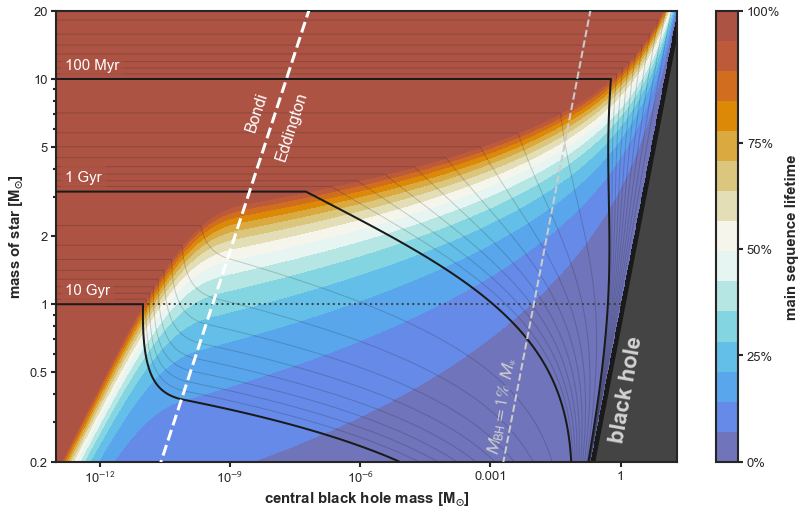

In [71]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
#levels = np.linspace(0, 100, 15)#[0, 25, 50, 75, 100]
levels = list(np.linspace(0, 99, 15)) + [100]#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    M_BH_linspace, Ms_linspace, frac_grid.T, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

#plt.gca().set_xticks([1, 10, 100])
#plt.gca().set_xticklabels([1, 10, 100])
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks)
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.ylim([0.2, 20])
plt.xlim([1e-13, 20])

plt.gca().set_xticks([10**0, 10**-3, 10**-6, 10**-9, 10**-12])
plt.gca().set_xticklabels([r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])
#plt.gca().set_xticks(10**np.arange(-13, 2, 1, dtype=float), minor=True)#[10**0, 10**-3, 10**-6, 10**-9, 10**-12])
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator(15))
plt.gca().xaxis.set_minor_locator(LogLocator(base=10,subs=[2.0,5.0]))

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#ac5344'
plt.axvspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
plt.text(0.5, 0.25, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=80)
#plt.text(5e-12, 2.5, 'survives main sequence', size=18, weight='bold', c='w', zorder=9999,
#        bbox=dict(facecolor=bgcolor, edgecolor='none', pad=12, alpha=0.75))

cbet = 'w'
plt.plot(BET_(Ms), Ms, lw=3, c=cbet, ls='--', zorder=999)
plt.text(1e-8, 4.4, 'Eddington', c='w', rotation=72, zorder=9999, size=16)
plt.text(20e-10,   5.9, 'Bondi', c='w', rotation=72, zorder=9999, size=16)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])
cont='k'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels, 
            colors=cont, zorder=9, alpha=0.2,
            linewidths=1)

plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels2, 
            colors=cont, zorder=9, 
            linewidths=2)
labelx = 1.6e-13
bbox = dict(facecolor=bgcolor,
                  edgecolor='none', pad=4, alpha=0.75)
plt.text(labelx,1*1.1,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,3.2*1.1,     '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,10*1.1,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)

"""
cont='k'#'#333333'#'#444444'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels3, 
            colors=cont, zorder=9, alpha=0.05,#linestyles='dotted', 
            linewidths=1)
"""

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2]:
    plt.plot(Ms/10**ii, Ms, c='#cccccc', ls='--', zorder=99, lw=2)
#plt.text(0.75e-5, 0.22, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=80)
plt.text(75e-5, 0.22, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='#cccccc', rotation=80)

plt.plot([1, 9e-12], [1, 1], ls=':', c='#444444')

plt.ylabel('mass of star [M$_{\mathbf{\odot}}$]')
plt.xlabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/lifetime.pdf')
plt.show()

In [72]:
blue = lambda M, M_BH: BET_(M)/M_BH + np.log(M / np.max([M_BH, BET_(M)])) - (1-0.08)/0.08 * 4*np.pi*G/k_(M)/c*t_ms(M)
print(blue(1, 1e-14))
blue = lambda Mstar, MBH: lifetime(Mstar, MBH) - t_ms(Mstar)
print(blue(1, 1e-14))

40021.63955656882
6958.0508317482845


 message: The solution converged.
 success: True
  status: 1
     fun: [-3.730e-14]
       x: [ 9.986e-12]
    nfev: 29
    fjac: [[-1.000e+00]]
       r: [ 6.985e+11]
     qtf: [ 1.086e-08]


Text(0, 0.5, 'blue')

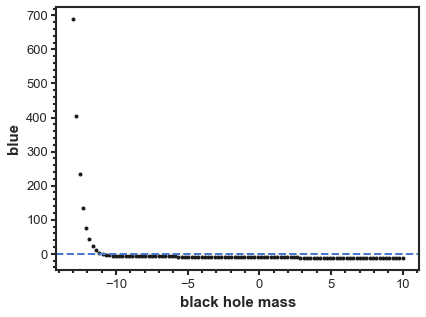

In [73]:
blue = lambda M, M_BH: BET_(M)/M_BH + np.log(M / np.max([M_BH, BET_(M)])) - (1-0.08)/0.08 * 4*np.pi*G/k_(M)/c*t_ms(M)
blue = lambda Mstar, MBH: lifetime(Mstar, MBH) - t_ms(Mstar)

print(root(lambda x: blue(1, x), x0=10**-10))

for x in np.linspace(-13, 10, 101):
    plt.plot(x, blue(1, 10**x), 'k.')
plt.axhline(0, ls='--')
plt.xlabel('black hole mass')
plt.ylabel('blue')
#plt.semilogy()
#root(lambda x: blue(x, 1e-10), x0=1.)

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


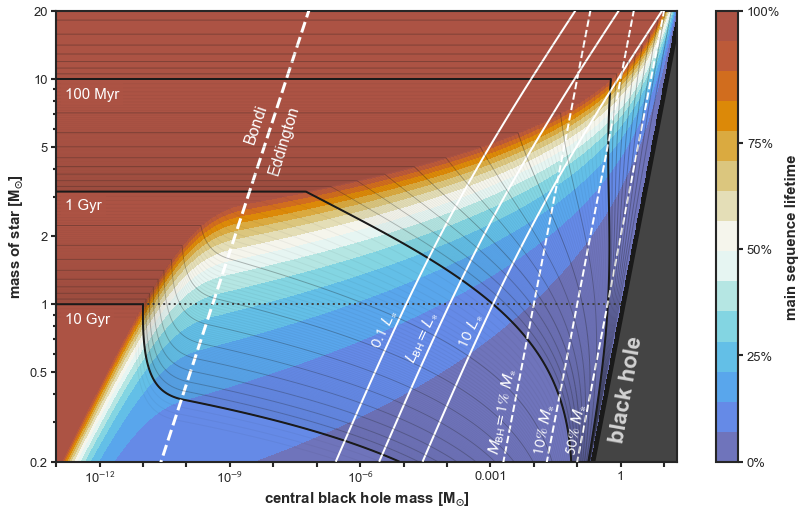

In [74]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
#levels = np.linspace(0, 100, 15)#[0, 25, 50, 75, 100]
levels = list(np.linspace(0, 99, 15)) + [100]#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    M_BH_linspace, Ms_linspace, frac_grid.T, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

#plt.gca().set_xticks([1, 10, 100])
#plt.gca().set_xticklabels([1, 10, 100])
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks)
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.ylim([0.2, 20])
plt.xlim([1e-13, 20])

#plt.gca().set_xticks([10**0, 10**-3, 10**-6, 10**-9, 10**-12])
xticks = [10**0, 10**-3, 10**-6, 10**-9, 10**-12]
xlabels = [r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$']
#plt.gca().set_xticklabels([r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])
xticksreal = 10**np.arange(-13, 2, 1, dtype=float)
plt.gca().set_xticks(xticksreal)
plt.gca().set_xticklabels([xlabels[xticks.index(x)] if x in xticks else '' for x in xticksreal])#r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])
#plt.gca().set_xticks(10**np.arange(-13, 2, 1, dtype=float), minor=True)#[10**0, 10**-3, 10**-6, 10**-9, 10**-12])
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator(15))
#plt.gca().xaxis.set_minor_locator(LogLocator(base=10,subs=[2.0,5.0]))

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#ac5344'
plt.axvspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
plt.text(0.5, 0.25, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=80)
#plt.text(5e-12, 2.5, 'survives main sequence', size=18, weight='bold', c='w', zorder=9999,
#        bbox=dict(facecolor=bgcolor, edgecolor='none', pad=12, alpha=0.75))

cbet = 'w'
plt.plot(BET_(Ms), Ms, lw=3, c=cbet, ls='--', zorder=999)
plt.text(0.7e-8, 3.8, 'Eddington', c='w', rotation=73, zorder=9999, size=16)
plt.text(20e-10,   5.2, 'Bondi', c='w', rotation=71, zorder=9999, size=16)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])
cont='k'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels, 
            colors=cont, zorder=999999, #zorder=9, 
            alpha=0.3,
            linewidths=1)

plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels2, 
            colors=cont, zorder=9, 
            linewidths=2)
labelx = 1.6e-13
bbox = dict(facecolor=bgcolor,
                  edgecolor='none', pad=4, alpha=0.85)
#plt.text(labelx,1*1.1,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(labelx,3.2*1.1, '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(labelx,10*1.1,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,1*0.82,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,3.2*0.82, '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,10*0.82,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)

#"""
cont='k'#'#333333'#'#444444'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2.T, levels=line_levels3, 
            colors=cont, zorder=9, alpha=0.05,#linestyles='dotted', 
            linewidths=1)
#"""

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2, 1]:
    plt.plot(Ms/10**ii, Ms, c='w', ls='--', zorder=99, lw=2)
plt.plot(Ms/2, Ms, c='w', ls='--', zorder=99, lw=2)
#plt.text(0.75e-5, 0.22, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=80)
plt.text(80e-5, 0.22, r'$M_{\rm{BH}} =  1\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(850e-5, 0.22, r'$10\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(4500e-5, 0.22, r'$50\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)

plt.contour(M_BH_linspace, Ms_linspace, luminosity_grid.T, levels=[0.1, 1, 10], colors='w', zorder=9999, linewidths=2)
plt.text(15e-7, 0.65, r'$0.1~L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(9.5e-6, 0.55, r'$L_{\rm{BH}} = L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(15e-5, 0.65, r'$10~L_\ast$', rotation=65, c='w', size=16, zorder=999999)

plt.plot([1, 9e-12], [1, 1], ls=':', c='#444444')

plt.ylabel('mass of star [M$_{\mathbf{\odot}}$]')
plt.xlabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/lifetime.pdf')
plt.show()

In [75]:
## visualize low metallicity (Z=1% solar)

frac_grid_lZ = np.array([[lifetime_lZ(Mstar, MBH)/t_ms(Mstar)*100 for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
frac_grid_lZ[frac_grid_lZ < 0] = np.nan
frac_grid_lZ[frac_grid_lZ > 100] = 100

lifetime_grid2_lZ = np.array([[np.min([lifetime_lZ(Mstar, MBH), t_ms(Mstar)]) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
lifetime_grid2_lZ[lifetime_grid2_lZ < 0] = np.nan
lifetime_grid2_lZ[lifetime_grid2_lZ > 100] = 100

luminosity_grid_lZ = np.array([[L_BH_lZ(Mstar, MBH) / L_MS(Mstar) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


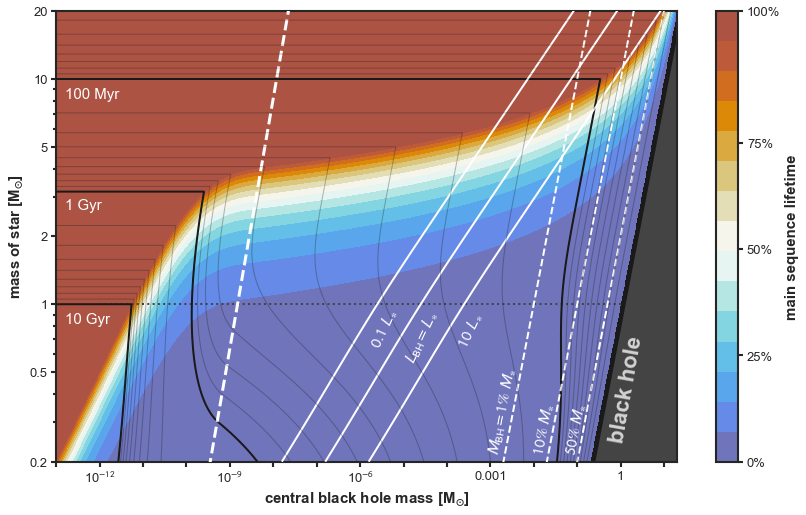

In [76]:
levels = list(np.linspace(0, 99, 15)) + [100]#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    M_BH_linspace, Ms_linspace, frac_grid_lZ.T, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks)
plt.ylim([0.2, 20])
plt.xlim([1e-13, 20])

xticks = [10**0, 10**-3, 10**-6, 10**-9, 10**-12]
xlabels = [r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$']
xticksreal = 10**np.arange(-13, 2, 1, dtype=float)
plt.gca().set_xticks(xticksreal)
plt.gca().set_xticklabels([xlabels[xticks.index(x)] if x in xticks else '' for x in xticksreal])

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#ac5344'
plt.axvspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
plt.text(0.5, 0.25, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=80)

cbet = 'w'
plt.plot(BET_lZ(Ms), Ms, lw=3, c=cbet, ls='--', zorder=999)
#plt.text(0.7e-8, 3.8, 'Eddington', c='w', rotation=73, zorder=9999, size=16)
#plt.text(20e-10,   5.2, 'Bondi', c='w', rotation=71, zorder=9999, size=16)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])
cont='k'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_lZ.T, levels=line_levels, 
            colors=cont, zorder=999999, #zorder=9, 
            alpha=0.3,
            linewidths=1)

plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_lZ.T, levels=line_levels2, 
            colors=cont, zorder=9, 
            linewidths=2)
labelx = 1.6e-13
bbox = dict(facecolor=bgcolor,
                  edgecolor='none', pad=4, alpha=0.85)
plt.text(labelx,1*0.82,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,3.2*0.82, '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,10*0.82,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)

"""
cont='k'#'#333333'#'#444444'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_lZ.T, levels=line_levels3, 
            colors=cont, zorder=9, alpha=0.05,#linestyles='dotted', 
            linewidths=1)
"""

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2, 1]:
    plt.plot(Ms/10**ii, Ms, c='w', ls='--', zorder=99, lw=2)
plt.plot(Ms/2, Ms, c='w', ls='--', zorder=99, lw=2)
#plt.text(0.75e-5, 0.22, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=80)
plt.text(80e-5, 0.22, r'$M_{\rm{BH}} =  1\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(850e-5, 0.22, r'$10\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(4500e-5, 0.22, r'$50\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)

plt.contour(M_BH_linspace, Ms_linspace, luminosity_grid_lZ.T, levels=[0.1, 1, 10], colors='w', zorder=9999, linewidths=2)
plt.text(15e-7, 0.65, r'$0.1~L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(9.5e-6, 0.55, r'$L_{\rm{BH}} = L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(15e-5, 0.65, r'$10~L_\ast$', rotation=65, c='w', size=16, zorder=999999)

plt.plot([1, 1e-12], [1, 1], ls=':', c='#444444')

plt.ylabel('mass of star [M$_{\mathbf{\odot}}$]')
plt.xlabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/lifetime_lZ.pdf')
#plt.show()

In [77]:
## visualize Clayton's model 

t_edd_C = lambda M, M_BH: tau_edd_C(M) * np.log(M / M_BH) / secGyr
tau_edd_C = lambda M: ((1-eps)/eps*4*pi*G/c/0.4)**-1
lifetime_C = lambda M, M_BH: t_edd_C(M, M_BH)

frac_grid_C = np.array([[lifetime_C(Mstar, MBH)/t_ms(Mstar)*100 for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
frac_grid_C[frac_grid_C < 0] = np.nan
frac_grid_C[frac_grid_C > 100] = 100

lifetime_grid2_C = np.array([[np.min([lifetime_C(Mstar, MBH), t_ms(Mstar)]) for Mstar in Ms_linspace]
                       for MBH in M_BH_linspace])
lifetime_grid2_C[lifetime_grid2_C < 0] = np.nan
lifetime_grid2_C[lifetime_grid2_C > 100] = 100

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


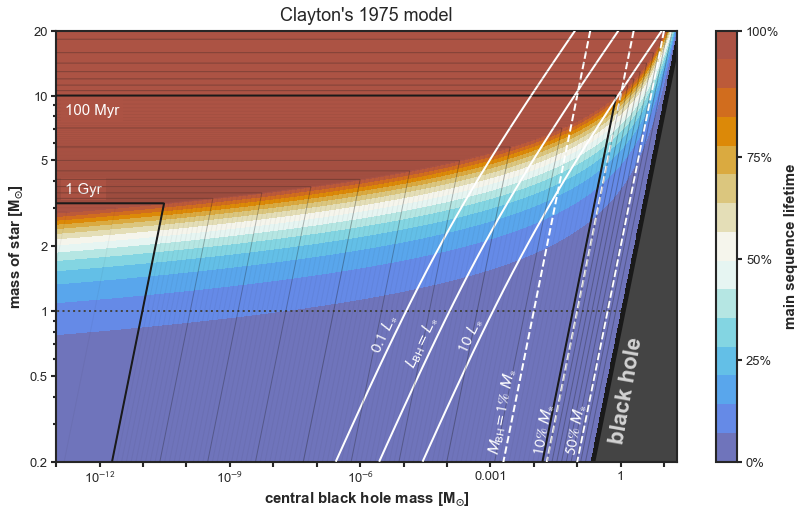

In [78]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
#levels = np.linspace(0, 100, 15)#[0, 25, 50, 75, 100]
levels = list(np.linspace(0, 99, 15)) + [100]#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    M_BH_linspace, Ms_linspace, frac_grid_C.T, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

#plt.gca().set_xticks([1, 10, 100])
#plt.gca().set_xticklabels([1, 10, 100])
yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(yticks)
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.ylim([0.2, 20])
plt.xlim([1e-13, 20])

#plt.gca().set_xticks([10**0, 10**-3, 10**-6, 10**-9, 10**-12])
xticks = [10**0, 10**-3, 10**-6, 10**-9, 10**-12]
xlabels = [r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$']
#plt.gca().set_xticklabels([r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])
xticksreal = 10**np.arange(-13, 2, 1, dtype=float)
plt.gca().set_xticks(xticksreal)
plt.gca().set_xticklabels([xlabels[xticks.index(x)] if x in xticks else '' for x in xticksreal])#r'1', r'0.001', r'10$^{-6}$', r'10$^{-9}$', r'10$^{-12}$'])
#plt.gca().set_xticks(10**np.arange(-13, 2, 1, dtype=float), minor=True)#[10**0, 10**-3, 10**-6, 10**-9, 10**-12])
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator(15))
#plt.gca().xaxis.set_minor_locator(LogLocator(base=10,subs=[2.0,5.0]))

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#ac5344'
plt.axvspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
plt.text(0.5, 0.25, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=80)
#plt.text(5e-12, 2.5, 'survives main sequence', size=18, weight='bold', c='w', zorder=9999,
#        bbox=dict(facecolor=bgcolor, edgecolor='none', pad=12, alpha=0.75))

#cbet = 'w'
#plt.plot(BET_(Ms), Ms, lw=3, c=cbet, ls='--', zorder=999)
#plt.text(0.7e-8, 3.8, 'Eddington', c='w', rotation=73, zorder=9999, size=16)
#plt.text(20e-10,   5.2, 'Bondi', c='w', rotation=71, zorder=9999, size=16)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])
cont='k'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_C.T, levels=line_levels, 
            colors=cont, zorder=999999, #zorder=9, 
            alpha=0.3,
            linewidths=1)

plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_C.T, levels=line_levels2, 
            colors=cont, zorder=9, 
            linewidths=2)
labelx = 1.6e-13
bbox = dict(facecolor=bgcolor,
                  edgecolor='none', pad=4, alpha=0.95)
#plt.text(labelx,1*1.1,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(labelx,3.2*1.1, '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(labelx,10*1.1,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)
#plt.text(labelx,1*0.82,   '10 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,3.2*1.1, '1 Gyr',  size=15, c='w', bbox=bbox, zorder=999)
plt.text(labelx,10*0.82,  '100 Myr',  size=15, c='w', bbox=bbox, zorder=999)

#"""
cont='k'#'#333333'#'#444444'
plt.contour(M_BH_linspace, Ms_linspace, lifetime_grid2_C.T, levels=line_levels3, 
            colors=cont, zorder=9, alpha=0.05,#linestyles='dotted', 
            linewidths=1)
#"""

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2, 1]:
    plt.plot(Ms/10**ii, Ms, c='w', ls='--', zorder=99, lw=2)
plt.plot(Ms/2, Ms, c='w', ls='--', zorder=99, lw=2)
#plt.text(0.75e-5, 0.22, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=80)
plt.text(80e-5, 0.22, r'$M_{\rm{BH}} =  1\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(850e-5, 0.22, r'$10\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)
plt.text(4500e-5, 0.22, r'$50\%~M_{\ast}$', c='w', rotation=79, zorder=999999, size=16)

plt.contour(M_BH_linspace, Ms_linspace, luminosity_grid.T, levels=[0.1, 1, 10], colors='w', zorder=9999, linewidths=2)
plt.text(15e-7, 0.65, r'$0.1~L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(9.5e-6, 0.55, r'$L_{\rm{BH}} = L_\ast$', rotation=65, c='w', size=16, zorder=999999)
plt.text(15e-5, 0.65, r'$10~L_\ast$', rotation=65, c='w', size=16, zorder=999999)

plt.plot([1, 1e-13], [1, 1], ls=':', c='#444444')

plt.ylabel('mass of star [M$_{\mathbf{\odot}}$]')
plt.xlabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.title("Clayton's 1975 model")

plt.tight_layout()
plt.savefig('figs/lifetime-Clayton.pdf')
#plt.show()

In [244]:
0.5977/10

0.059770000000000004

In [241]:
#root(lambda x: lifetime(10, x)/t_ms(10)*100-100, x0=1)
lifetime(10, 0.5977)/t_ms(10)*100

100.00014051918083

In [246]:
#root(lambda x: lifetime(20, x)/t_ms(20)*100-100, x0=1)
lifetime(20, 9.151)/t_ms(20)*100

100.00221200371418

In [63]:
lifetime(1, 1e-2)

0.68082831818702

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


[2.e-03 3.e-03 4.e-03 5.e-03 6.e-03 7.e-03 8.e-03 9.e-03 2.e-02 3.e-02
 4.e-02 5.e-02 6.e-02 7.e-02 8.e-02 9.e-02 2.e-01 3.e-01 4.e-01 5.e-01
 6.e-01 7.e-01 8.e-01 9.e-01 2.e+00 3.e+00 4.e+00 5.e+00 6.e+00 7.e+00
 8.e+00 9.e+00]


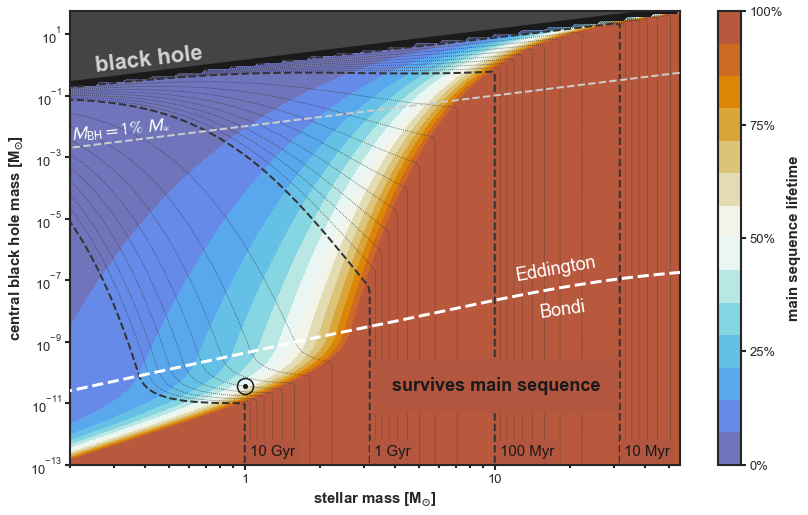

In [74]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
levels = np.linspace(0, 100, 15)#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    Ms_linspace, M_BH_linspace, frac_grid, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag_r,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.xlim([0.2, 55])
plt.ylim([1e-13, 55])

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

bgcolor = '#b3563f'
plt.axhspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
#plt.text(0.25, 8, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999)
plt.text(0.25, 0.6, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=6.8)
plt.text(3.9, 2.5e-11, 'survives main sequence', size=18, weight='bold', c='k', zorder=9999,
        bbox=dict(facecolor=bgcolor,#'#f7e425',#'#f3db42', 
                  edgecolor='none', pad=18))

cbet = 'w'#'#444444'
plt.plot(Ms, BETs, lw=3, c=cbet, ls='--', zorder=999)
plt.text(12, 1e-7, 'Eddington', c='w', rotation=10, zorder=9999)
plt.text(15, 6e-9, 'Bondi', c='w', rotation=8, zorder=9999)

levels = [0, 25, 50, 75, 100]
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])

cont='#333333'#'#444444'
line_levels = np.concatenate([np.arange(2, 10) * 10**j for j in range(-3, 3)] + [np.array([10**7])])
line_levels = line_levels[line_levels < 13.799]
print(line_levels)
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels, 
            colors=cont, zorder=9, linestyles='dotted', linewidths=0.75)

line_levels = [0.01, 0.1, 1, 10]
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels, 
            colors=cont, zorder=9, linestyles='dashed', linewidths=2)
labely = 2e-13
bbox = dict(facecolor=bgcolor,#'#f7e425',#'#f3db42', 
                  edgecolor='none', pad=4)
plt.text(1.05, labely,  '10 Gyr',  size=15, c='k', bbox=bbox, zorder=999)
plt.text(3.3,  labely,   '1 Gyr',  size=15, c='k', bbox=bbox, zorder=999)
plt.text(10.5, labely, '100 Myr',  size=15, c='k', bbox=bbox, zorder=999)
plt.text(33,   labely,  '10 Myr',  size=15, c='k', bbox=bbox, zorder=999)

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)
for ii in [2]:
    plt.plot(Ms, Ms/10**ii, c='#cccccc', ls='--', zorder=99, lw=2)
plt.text(0.2, 3.5e-3, r'$M_{\rm{BH}} = 1\%~M_{\ast}$', c='w', rotation=6)

plt.plot(1, 3.527e-11, c='k', marker='.', zorder=99999, ms=8)
plt.plot(1, 3.527e-11, c='k', marker='o', mew=1.5, mfc='none', zorder=99999, ms=16)

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('central black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.savefig('figs/lifetime.pdf')
plt.show()

C:\Users\earlb\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


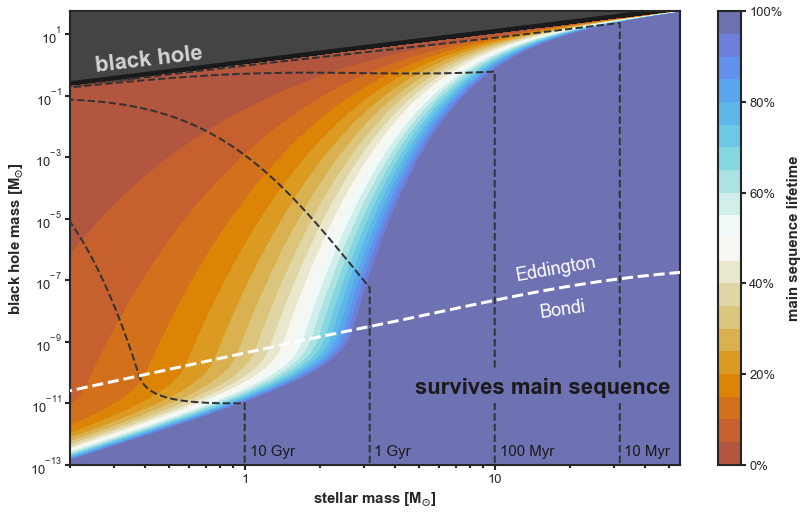

In [552]:
#levels = 10**np.linspace(-3, 2, 51)
#norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
levels = np.linspace(0, 100, 21)#[0, 25, 50, 75, 100]
norm = mpl.colors.Normalize(vmin=0, vmax=100)

plt.figure(figsize=(4*(3), 5*(1.5)))
contour = plt.contourf(
    Ms_linspace, M_BH_linspace, frac_grid, norm=norm, #antialiased=False,
    cmap=cmr.prinsenvlag,#'tab20c_r', 
    levels=levels, zorder=-2)

plt.gca().set_rasterization_zorder(-1)

plt.semilogy()
plt.semilogx()

plt.plot(Ms, Ms, lw=10, c='k', zorder=-3)

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])
#plt.xlim([Ms_linspace.min(), Ms_linspace.max()])
plt.xlim([0.2, 55])
plt.ylim([1e-13, 55])

cbar = plt.colorbar(contour)
cbar.set_label('main sequence lifetime')

plt.axhspan(0.1, 1000, 1e-18, 1e3, color='#444444', zorder=-999)
#plt.text(0.25, 8, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999)
plt.text(0.25, 0.6, 'black hole', size=22, weight='bold', c='lightgray', zorder=9999, rotation=6.8)
plt.text(4.8, 2.1e-11, 'survives main sequence', size=22, weight='bold', c='k', zorder=9999,
        bbox=dict(facecolor='#6e72b3',#'#f7e425',#'#f3db42', 
                  edgecolor='none', pad=6))

cbet = 'w'#'#444444'
plt.plot(Ms, BETs, lw=3, c=cbet, ls='--', zorder=999)
plt.text(12, 1e-7, 'Eddington', c='w', rotation=10, zorder=9999)
plt.text(15, 6e-9, 'Bondi', c='w', rotation=8, zorder=9999)

#cbar.set_ticks([1e-3, 1e-2, 1e-1, 1, 10, 100])
#cbar.set_ticks(levels)
levels = np.linspace(0, 100, 6)
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) + '%' for level in levels])
#cbar.set_ticklabels(['0.001%', '0.01%', '0.1%', '1%', '10%', '100%'])

cont='#333333'#'#444444'
line_levels = [0.01, 0.1, 1, 10]
plt.contour(Ms_linspace, M_BH_linspace, lifetime_grid2, levels=line_levels, 
            colors=cont, zorder=9, linestyles='dashed', linewidths=2)
labely = 2e-13
plt.text(1.05, labely, '10 Gyr',  size=15, c='k')
plt.text(3.3,  labely, '1 Gyr',   size=15, c='k')
plt.text(10.5, labely, '100 Myr', size=15, c='k')
plt.text(33,   labely, '10 Myr',  size=15, c='k')
#plt.text(105,  labely, '1 Myr',   size=15, c='k')

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
#plt.savefig('figs/lifetime.pdf')
plt.show()

Text(0, 0.5, 'lifetime [%]')

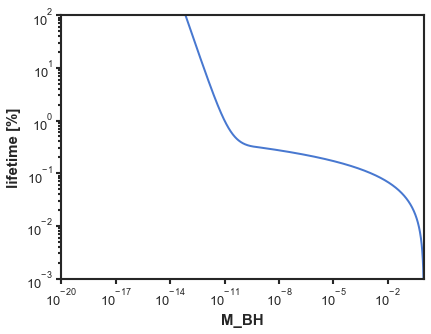

In [446]:
plt.plot(M_BH_linspace, [lifetime(1, M_BH)/t_ms(1) for M_BH in M_BH_linspace])
plt.semilogx()
plt.semilogy()
plt.xlim([1e-20, 1])
plt.ylim([1e-3, 100])
plt.xlabel('M_BH')
plt.ylabel('lifetime [%]')

In [100]:
Ms_grid, M_BH_grid = np.meshgrid(10**np.linspace(np.log10(0.2), np.log10(200), 100), 
                                 10**np.linspace(-12, 2, 100))

lifetime_grid = lifetime(Ms_grid, M_BH_grid)
lifetime_grid[lifetime_grid < 0] = np.nan
lifetime_grid[lifetime_grid > 100] = 100

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
lifetime(1, 1e-3)

1.02124247728053

In [1259]:
np.exp((1/1e-8)/M_sun)

1.0

In [1333]:
(1-0.08)/0.08 * 4 * np.pi * G / c / 1.5 * np.log(1/1e-9)/M_sun * secGyr

7.049533209136652e-32

In [1095]:
Ms_grid, M_BH_grid = np.meshgrid(10**np.linspace(np.log10(0.2), np.log10(200), 1000), 10**np.linspace(-12, -5, 1000))

# Calculate t_bondi for each pair in the grid
t_bondi_grid = t_bondi(Ms_grid, M_BH_grid)

# Set negative values of t_bondi to NaN
t_bondi_grid[t_bondi_grid < 0] = np.nan
t_bondi_grid[t_bondi_grid > 100] = 100

levels = 1/np.array([1e-6, 1e-3, 1, 10, 100])[::-1]

ticks = [1e-6, 1e-3, 1, 10, 100]
levels = np.array(ticks)#/50

# Create the contour plot
plt.figure(figsize=(4*(3/2), 5))
contour = plt.contourf(
    Ms_grid, M_BH_grid, np.log10(t_bondi_grid), 
    norm=mpl.colors.Normalize(vmin=-9, vmax=),
    cmap='RdBu', levels=levels)

plt.semilogy()
plt.semilogx()

plt.gca().set_xticks([1, 10, 100])
plt.gca().set_xticklabels([1, 10, 100])

# Add colorbar and labels
cbar = plt.colorbar(contour)
cbar.set_label('time until Eddington limit')

# Set colorbar ticks and labels
cbar.set_ticks(ticks)
cbar.set_ticklabels(['1 kyr', '1 Myr', '1 Gyr', '10 Gyr', '>100 Gyr'])

plt.xlabel('stellar mass [M$_{\mathbf{\odot}}$]')
plt.ylabel('black hole mass [M$_{\mathbf{\odot}}$]')

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (<ipython-input-1095-cc0bcf3fbbf3>, line 19)

In [1028]:
t_bondi_grid

array([[1.79760799e+07, 2.10910186e+09, 4.31130201e+09, ...,
        1.22935109e+10, 1.23247636e+10, 1.23552542e+10],
       [1.73252286e+07, 2.03273862e+09, 4.15520477e+09, ...,
        1.18484057e+10, 1.18785268e+10, 1.19079135e+10],
       [1.66979423e+07, 1.95914023e+09, 4.00475927e+09, ...,
        1.14194161e+10, 1.14484467e+10, 1.14767694e+10],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

Text(0, 0.5, 'M_BH')

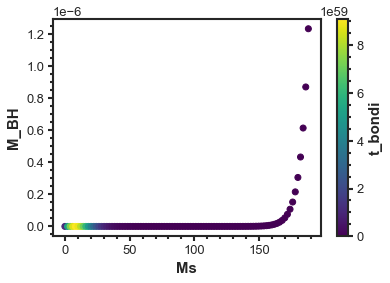

In [830]:
plt.scatter(Ms, M_BH, c=t_bondis, cmap='viridis')

# Add colorbar and labels
cbar = plt.colorbar()
cbar.set_label('t_bondi')
plt.xlabel('Ms')
plt.ylabel('M_BH')

In [821]:
t_bondi(1, 1e-10)

3.5734282704374295e+49

In [489]:
10**-20*cnt.M_sun.to(unt.g)

<Quantity 1.98840987e+13 g>

In [394]:
diff(1, M_BH)

array([ 4.54516356e+07,  8.12970465e+07,  1.45411924e+08,  2.60090969e+08,
        4.65211590e+08,  8.32100491e+08,  1.48833615e+09,  2.66211176e+09,
        4.76158494e+09,  8.51680666e+09,  1.52335822e+10,  2.72475397e+10,
        4.87362990e+10,  8.71721583e+10,  1.55920440e+11,  2.78887021e+11,
        4.98831139e+11,  8.92234082e+11,  1.59589407e+12,  2.85449518e+12,
        5.10569146e+12,  9.13229262e+12,  1.63344709e+13,  2.92166437e+13,
        5.22583359e+13,  9.34718480e+13,  1.67188377e+14,  2.99041412e+14,
        5.34880280e+14,  9.56713361e+14,  1.71122490e+15,  3.06078162e+15,
        5.47466559e+15,  9.79225804e+15,  1.75149177e+16,  3.13280493e+16,
        5.60349007e+16,  1.00226799e+17,  1.79270616e+17,  3.20652304e+17,
        5.73534592e+17,  1.02585238e+18,  1.83489037e+18,  3.28197580e+18,
        5.87030447e+18,  1.04999173e+19,  1.87806722e+19,  3.35920404e+19,
        6.00843872e+19,  1.07469911e+20,  1.92226005e+20,  3.43824952e+20,
        6.14982334e+20,  

In [262]:
from sympy import symbols, log, exp, pi, nsolve

In [265]:
# define symbols
M, M_BH = symbols('M, M_BH')

# constants
G = 6.67408e-11  # gravitational constant
c = 2.998e8  # speed of light

# expressions
u = 1.6e7 * (log(M, 10) + 3.5)
k = 0.8 * 0.02**M + 0.3
rho = 10**(-1.8 / (1 + exp(-2.6 * M - 0.9))) + 2

# equation to solve
eq = 4*pi*G*c/k*M_BH - 16*pi*0.08*(1-0.08)*rho/(u*(5/3))*(G*M_BH)**2

# initial guess for M
M0 = 1

# solve equation numerically
M_value = nsolve(eq, M, M0)

print(M_value)


ValueError: 
expected a one-dimensional and numerical function

In [268]:
import sympy as sp

In [271]:


# Define the symbols
M, MBH, G, c = sp.symbols('M MBH')

# Constants
pi = sp.pi
G = 6.67408e-11
c = 2.998e8

# Define the functions
u = 1.6*10**7*(sp.log(M, 10)+3.5)
k = 0.8*0.02**M+0.3
rho = 10**( -1.8 / ( 1 + sp.exp(-2.6 * M - 0.9) ) ) + 2

# Define the equation
eq = 4*pi*G*c/k*MBH - 16*pi*0.08*(1-0.08)*rho/(u*(5/3))*(G*MBH)**2


ValueError: not enough values to unpack (expected 4, got 2)

In [272]:
eq

-1.1776*pi*G**2*MBH**2*(2 + 10**(-1.8/(1 + 0.406569659740599*exp(-2.6*M))))/(26666666.6666667*log(M)/log(10) + 93333333.3333333) + 4*pi*G*MBH*c/(0.8*0.02**M + 0.3)

In [273]:

# Solve the equation for M
solution = sp.solve(eq, M)

# Print the solution
print("Solution: ", solution)


KeyboardInterrupt: 

In [267]:
5+5

10